In [1]:
library(knitr)
library(ggplot2)
library(summarytools)
library(GGally)
library(corrplot)
library(WVPlots)
library(psych)
library(mltools)
library(caret)
library(glmnet)
library(rpart)
library(rfUtilities)
options(warn=-1) #Disable warnings

Registered S3 method overwritten by 'pryr':
  method      from
  print.bytes Rcpp

For best results, restart R session and update pander using devtools:: or remotes::install_github('rapporter/pander')

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

corrplot 0.84 loaded


Attaching package: 'psych'


The following objects are masked from 'package:ggplot2':

    %+%, alpha


Loading required package: lattice

Loading required package: Matrix

Loaded glmnet 4.0



# Task 1 - Data exploration

In [2]:
#Loading data
groups <- read.csv("Data/groups.csv", stringsAsFactors = F)
voters <- read.csv("Data/voters.csv", stringsAsFactors = F)

## Question 1. Of the voters in the groups.csv file, how many of them are not in the voting record file.

In [3]:
length(groups$voterid)
length(voters$userid)

[1] 125108

[1] 135000

In [ ]:
groupsId_To_VoterId = function(groupsId,votersDataframe){
    #Check if the groupId has the proper format (A 'V' before the numbers)
    if(substr(groupsId,0,1) != 'V'){
        "groupsId value is not properly formatter"
    } else{
        #Cutting the group id to have the same format as voterId
        groupsCutID = substr(groupsId,2,100000)
    }
    isGroupIdInVoterId = dim(votersDataframe[which(votersDataframe$userid == groupsCutID),])[1]
    
    return(isGroupIdInVoterId)
    
}

#For the first version I will 'bruteforce' my way through this question
groupVotersInRecord = 0
groupVotersInRecord_NOT = 0
pb <- txtProgressBar(min = 0, max = length(groups$voterid), style = 3)
for(i in seq(1,length(groups$voterid))){
    #Check if each voter in the groups list is in the voters list
    is_voter_in_list = groupsId_To_VoterId(toString(groups$voterid[i]),voters)
    #If it is, add 1 to our count of voters in record
    groupVotersInRecord = groupVotersInRecord + is_voter_in_list
    
    #If the voter is not in the list, we will append to an
        # index list so that we can remove them later
    if(is_voter_in_list == 0){
        groupVotersInRecord_NOT = groupVotersInRecord_NOT + 1
    }
    setTxtProgressBar(pb, i)
}

print(groupVotersInRecord)
print(groupVotersInRecord_NOT)
print(groupVotersInRecord / (groupVotersInRecord + groupVotersInRecord_NOT ))


  |=                                                                     |   1%

### Answer: of the voters in the groups.csv file, 73% are not in the voting record

In this next section we transform the ID's from both our dataframes into a common value, so we can merge the data.

In [5]:
#Transform the voters id into a zero padded number 
pb <- txtProgressBar(min = 0, max = length(voters$userid), style = 3)
for(i in seq(1,length(voters$userid))){
    voters$userid[i] = formatC(as.numeric(voters$userid[i]), digits = 5, flag = "0")
    setTxtProgressBar(pb, i)
}

  |======================================================================| 100%

In [6]:
#Renaming the dataframes so as to merge them
colnames(groups)[1] <- "ID"
colnames(voters)[1] <- "ID"

In [7]:
voters

ID,first.name,last.name,sex,yob,voting2005,voting2006
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
006860,Omar,el-Sham,1,1939,0,0
088596,Kyana,Chavez,1,1972,1,0
1.2258e+05,Ramza,Okbamicael,1,1952,0,0
065331,Mazeeda,Tran,0,1966,0,1
091971,Tenai,Eun,0,1950,0,0
1.0859e+05,Laaiqa,el-Sulaiman,0,1955,0,0
042059,Jalen,Carlsen,0,1970,0,0
008798,Monica,Pena,0,1954,0,0
007191,Marcus,Juarez,1,1941,0,0


In [8]:
completeData = merge(groups, voters, by ="ID")

After all the previous data reshaping, we still do not have an answer. For this we will do a simple for loop

## Question 2, of the voters in the groups.csv file, for which we have a voting record, what percentage of them voted in 2006?


In [9]:
percentage_of_2016_voters = sum(completeData$voting2006)/length(completeData$voting2006)
print(percentage_of_2016_voters)

[1] 0.2642495


### ANSWER: Our percentage of voters was: 26%

## Question 3 - Are the 5 groups exclusive of each other? How many voters for which we have voter records are listed as in multiple groups?


In [10]:
pb <- txtProgressBar(min = 0, max = length(completeData$control), style = 3)
groups_with_more_than_1_value = list()
for (i in seq(1,length(completeData$control))){
    civicduty_val = completeData$civicduty[i]
    hawthorne_val = completeData$hawthorne[i]
    self_val = completeData$self[i]
    neighbors_val = completeData$neighbors[i]
    control_val = completeData$control[i]
    
    if(sum(civicduty_val,hawthorne_val,self_val,neighbors_val,control_val) > 1){
        groups_with_more_than_1_value = append(groups_with_more_than_1_value, i)
    }
    setTxtProgressBar(pb, i)
}

  |======================================================================| 100%

In [11]:
#Checking if our function worked
completeData[as.numeric(groups_with_more_than_1_value[1]),]

,ID,civicduty,hawthorne,self,neighbors,control,first.name,last.name,sex,yob,voting2005,voting2006
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>
9269,010895,0,1,0,1,0,Nawf,Jamieson,0,1943,1,0


In [12]:
length(groups_with_more_than_1_value)
length(completeData$control)

[1] 11

[1] 85196

### ANSWER: There were 11 voter listed as duplicates

Now we delete the rows where there are typos

In [13]:
completeData <- completeData[-c(as.numeric(groups_with_more_than_1_value)),] 

In [49]:
length(completeData$control)

[1] 85185

## Question 4 - Of the remaining voters, what percentage of them are in each of the following age groups:

In [15]:
pb <- txtProgressBar(min = 0, max = length(completeData$control), style = 3)

newAgeColumn = list()
for (i in seq(1,length(completeData$control))){
    age = 2006 - completeData$yob[i]
    newAgeColumn = append(newAgeColumn,age)    
    setTxtProgressBar(pb, i)
}


  |======================================================================| 100%

In [16]:
#get the new values into the data
completeData$age = newAgeColumn

In [56]:
completeData$age[1:2]

[[1]]
[1] 54

[[2]]
[1] 59

In [57]:
#This code is a bit "hacky", this list will be used to 
    # calculate the percentages of each ageGroup
Age_18_30 = list()
Age_31_40 = list()
Age_41_50 = list()
Age_51_65 = list()
Age_65_all = list()

pb <- txtProgressBar(min = 0, max = length(completeData$control), style = 3)
for (i in seq(1,length(completeData$control))){
    age = completeData$age[i]
    #This can definetly be automated
    if(age < 31){
        Age_18_30 = append(Age_18_30,1)
        Age_31_40 = append(Age_31_40,0)
        Age_41_50 = append(Age_41_50,0)
        Age_51_65 = append(Age_51_65,0)
        Age_65_all = append(Age_65_all,0)
    }else if (age < 41){
        Age_18_30 = append(Age_18_30,0)
        Age_31_40 = append(Age_31_40,1)
        Age_41_50 = append(Age_41_50,0)
        Age_51_65 = append(Age_51_65,0)
        Age_65_all = append(Age_65_all,0)
    }else if (age < 51){
        Age_18_30 = append(Age_18_30,0)
        Age_31_40 = append(Age_31_40,0)
        Age_41_50 = append(Age_41_50,1)
        Age_51_65 = append(Age_51_65,0)
        Age_65_all = append(Age_65_all,0)
    }else if (age < 65){
        Age_18_30 = append(Age_18_30,0)
        Age_31_40 = append(Age_31_40,0)
        Age_41_50 = append(Age_41_50,0)
        Age_51_65 = append(Age_51_65,1)
        Age_65_all = append(Age_65_all,0)
    }else{
        Age_18_30 = append(Age_18_30,0)
        Age_31_40 = append(Age_31_40,0)
        Age_41_50 = append(Age_41_50,0)
        Age_51_65 = append(Age_51_65,0)
        Age_65_all = append(Age_65_all,1)
    }
    
    setTxtProgressBar(pb, i)
}


  |======================================================================| 100%

In [60]:
percentage_18 = sum(as.numeric(Age_18_30)) / length(completeData$control)
percentage_31 = sum(as.numeric(Age_31_40)) / length(completeData$control)
percentage_41 = sum(as.numeric(Age_41_50)) / length(completeData$control)
percentage_51 = sum(as.numeric(Age_51_65)) / length(completeData$control)
percentage_65 = sum(as.numeric(Age_65_all)) / length(completeData$control)

print(percentage_18)
print(percentage_31)
print(percentage_41)
print(percentage_51)
print(percentage_65)

[1] 0.08377062
[1] 0.1262781
[1] 0.2808945
[1] 0.3553912
[1] 0.1536656


### Answer - The percentages of voters per age group are:
* 18-30: 8%
* 31-40: 13%
* 41-50: 28%
* 51-65: 36%
* 65-all: 15%

In [17]:
ageGroup = list()

pb <- txtProgressBar(min = 0, max = length(completeData$control), style = 3)
for (i in seq(1,length(completeData$age))){
    age = completeData$age[i]
    #This can definetly be automated
    if(age < 31){
        ageGroup = append(ageGroup,"Age_18_30")
    } else if (age < 41){
        ageGroup = append(ageGroup,"Age_31_40")
    } else if (age < 51){
        ageGroup = append(ageGroup,"Age_41_50")
    } else if (age < 65){
        ageGroup = append(ageGroup,"Age_51_65")
    }else{
        ageGroup = append(ageGroup,"Age_65_all")
    }
    setTxtProgressBar(pb, i)
}


  |======================================================================| 100%

In [18]:
completeData$age_group = ageGroup

In [19]:
head(completeData)

,ID,civicduty,hawthorne,self,neighbors,control,first.name,last.name,sex,yob,voting2005,voting2006,age,age_group
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<list>,<list>
1,000001,0,0,0,0,1,Lucas,Cervantes,1,1952,0,1,54,Age_51_65
2,000002,1,0,0,0,0,Kelsy,Douglas,0,1947,0,0,59,Age_51_65
3,000005,0,0,0,0,1,Oyate,Chen,0,1970,1,1,36,Age_31_40
4,000006,0,0,0,1,0,Derrick,Peoples,0,1948,0,1,58,Age_51_65
5,000007,0,0,0,0,1,Yevanit,Thai,0,1922,0,0,84,Age_65_all
6,000008,1,0,0,0,0,Mikkayla,al-Yousef,1,1976,0,0,30,Age_18_30


In [63]:
length(Age_18_30[1:length(Age_18_30)])

[1] 85185

In [64]:
one_hot_encoded_data <- completeData
one_hot_encoded_data$Age_18_30 <- Age_18_30[1:length(Age_18_30)]
one_hot_encoded_data$Age_31_40 <- Age_31_40[1:length(Age_31_40)]
one_hot_encoded_data$Age_41_50 <- Age_41_50[1:length(Age_41_50)]
one_hot_encoded_data$Age_51_65 <- Age_51_65[1:length(Age_51_65)]
one_hot_encoded_data$Age_65_all <- Age_65_all[1:length(Age_65_all)]

## Question - For each age group, what percentage of people voted in 2006? Which age group had the largest percentage of people vote?

In [67]:
#Creating a dataframe to group age_groups (one_hot) and if they voted
AgeGroupsAndVotingDataFrame <- completeData
AgeGroupsAndVotingDataFrame$Age_18_30 <- Age_18_30[1:length(Age_18_30)]
AgeGroupsAndVotingDataFrame$Age_31_40 <- Age_31_40[1:length(Age_31_40)]
AgeGroupsAndVotingDataFrame$Age_41_50 <- Age_41_50[1:length(Age_41_50)]
AgeGroupsAndVotingDataFrame$Age_51_65 <- Age_51_65[1:length(Age_51_65)]
AgeGroupsAndVotingDataFrame$Age_65_all <- Age_65_all[1:length(Age_65_all)]

AgeGroupsAndVotingDataFrame$civicduty <- completeData$civicduty
AgeGroupsAndVotingDataFrame$hawthorne <- completeData$hawthorne
AgeGroupsAndVotingDataFrame$self <- completeData$self
AgeGroupsAndVotingDataFrame$neighbors <- completeData$neighbors
AgeGroupsAndVotingDataFrame$control <- completeData$control
AgeGroupsAndVotingDataFrame$voted2006 <- completeData$voting2006


In [71]:
voters_18 <- as.numeric(AgeGroupsAndVotingDataFrame$Age_18_30) * as.numeric(AgeGroupsAndVotingDataFrame$voted2006)
voters_31 <- as.numeric(AgeGroupsAndVotingDataFrame$Age_31_40) * as.numeric(AgeGroupsAndVotingDataFrame$voted2006)
voters_41 <- as.numeric(AgeGroupsAndVotingDataFrame$Age_41_50) * as.numeric(AgeGroupsAndVotingDataFrame$voted2006)
voters_51 <- as.numeric(AgeGroupsAndVotingDataFrame$Age_51_65) * as.numeric(AgeGroupsAndVotingDataFrame$voted2006)
voters_65 <- as.numeric(AgeGroupsAndVotingDataFrame$Age_65_all) * as.numeric(AgeGroupsAndVotingDataFrame$voted2006)

In [72]:
percentage_18 = sum(as.numeric(voters_18)) / length(completeData$control)
percentage_31 = sum(as.numeric(voters_31)) / length(completeData$control)
percentage_41 = sum(as.numeric(voters_41)) / length(completeData$control)
percentage_51 = sum(as.numeric(voters_51)) / length(completeData$control)
percentage_65 = sum(as.numeric(voters_65)) / length(completeData$control)

print(percentage_18)
print(percentage_31)
print(percentage_41)
print(percentage_51)
print(percentage_65)

[1] 0.02150613
[1] 0.03502964
[1] 0.07374538
[1] 0.09568586
[1] 0.03828139


### Answer - The percentages of voters in 2006 per age group are:
(Percentage of total citizens of the age group that vote)
* 18-30: 2%
* 31-40: 4%
* 41-50: 7%
* 51-65: 10%
* 65-all: 4%

The age group with largest voting percentage was: the ages 51 to 65, one must notice that this group is also the group with the largest age range, which possibly contributes to this result.

## Question - For each treatment group, what percentage of people voted in 2006? Which treatment group had the largest percentage of people vote?



In [73]:
#Creating a dataframe to group age_groups (one_hot) and if they voted
group_civic <- AgeGroupsAndVotingDataFrame$civicduty * AgeGroupsAndVotingDataFrame$voted2006
group_hawthorne <- AgeGroupsAndVotingDataFrame$hawthorne * AgeGroupsAndVotingDataFrame$voted2006
group_self <- AgeGroupsAndVotingDataFrame$self * AgeGroupsAndVotingDataFrame$voted2006
group_neighbors <- AgeGroupsAndVotingDataFrame$neighbors * AgeGroupsAndVotingDataFrame$voted2006
group_control <- AgeGroupsAndVotingDataFrame$control * AgeGroupsAndVotingDataFrame$voted2006

percentage_civic = sum(as.numeric(group_civic)) / length(completeData$control)
percentage_hawthorne = sum(as.numeric(group_hawthorne)) / length(completeData$control)
percentage_self = sum(as.numeric(group_self)) / length(completeData$control)
percentage_neighbors = sum(as.numeric(group_neighbors)) / length(completeData$control)
percentage_control = sum(as.numeric(group_control)) / length(completeData$control)

print(percentage_civic)
print(percentage_hawthorne)
print(percentage_self)
print(percentage_neighbors)
print(percentage_control)


[1] 0.05756882
[1] 0.04628749
[1] 0.05736926
[1] 0.06239361
[1] 0.04055878


### Answer - The percentages of voters in 2006 per age group are:
* civic: 6%
* hawthorne: 5%
* self: 6%
* neighbors: 6%
* control: 4%

The age group with largest voting in 2006 percentage was: the Neighbhors

# Task 2 - Data visualization

Note: we only used data for 2006 voters, so as not to confuse our audience when there is 2005 or 2006 data

## 1. Stacked bar chart - voter breakdown
showing the breakdown by age group (18-30, 31-40, 41-50, 51-64, 65+)
of the number of voters vs non-voters, i.e., the X-axis should be the Age Group, the Y-axis should be the count of people with voting records. Each stack will be composed of the non-voters and the voters and will sum to the number of people in the age group.

In [122]:
sum_vote_18 <- sum(voters_18)
total_18 <- sum(as.numeric(AgeGroupsAndVotingDataFrame$Age_18_30))
sum_vote_31 <- sum(voters_31)
total_31 <- sum(as.numeric(AgeGroupsAndVotingDataFrame$Age_31_40))
sum_vote_41 <- sum(voters_41)
total_41 <- sum(as.numeric(AgeGroupsAndVotingDataFrame$Age_41_50))
sum_vote_51 <- sum(voters_51)
total_51 <- sum(as.numeric(AgeGroupsAndVotingDataFrame$Age_51_65))
sum_vote_65 <- sum(voters_65)
total_65 <- sum(as.numeric(AgeGroupsAndVotingDataFrame$Age_65_all))

stackedValues = list(sum_vote_18, total_18, sum_vote_31, total_31,
                     sum_vote_41, total_41,
                     sum_vote_51, total_51,
                     sum_vote_65, total_65)

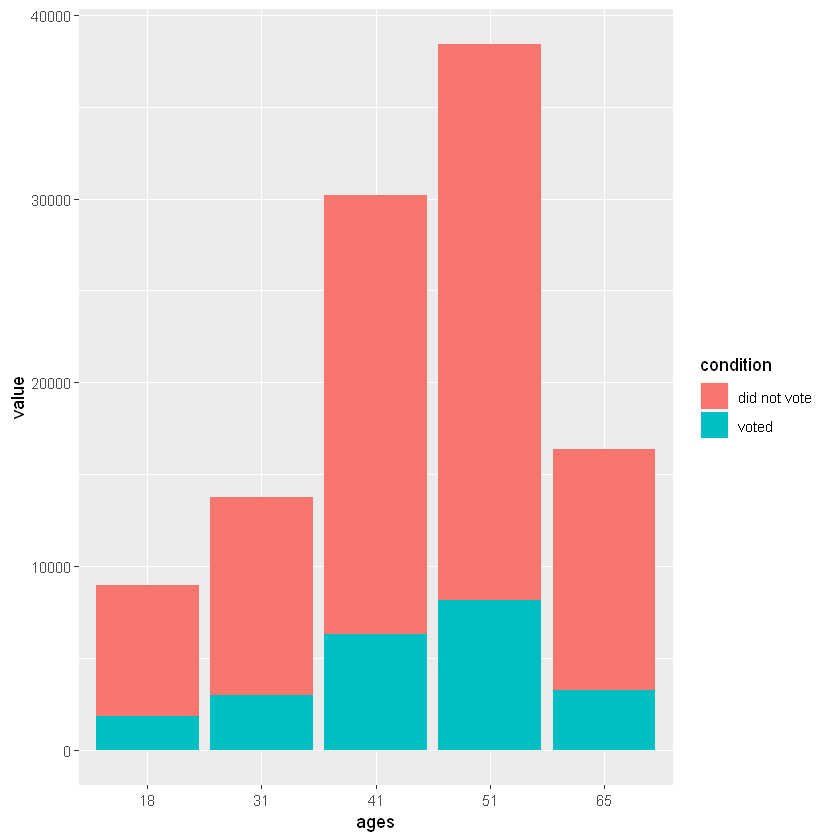

In [123]:
ages <- c( rep("18",2), rep("31",2), rep("41",2), rep("51",2),rep("65",2))
condition <- rep(c("voted", "did not vote"),5)
value <- abs(as.numeric(stackedValues))

ggplot_data_stacked_1 <- data.frame(ages,condition,value)

ggplot(ggplot_data_stacked_1, aes(fill=condition, y=value, x=ages)) + 
    geom_bar(position="stack", stat="identity")

## 2. Stacked bar chart - group breakdown
showing the breakdown by Groups (treatments + control) of the
percentage of people who voted, i.e., the X-axis should be the Group Name and the Y-axis should be the percentage of people who voted. Each stack will be composed of the nonvoters and the voters and will sum to 100%.

In [131]:
sum_civic <- sum(group_civic)
total_civic <- sum(AgeGroupsAndVotingDataFrame$civicduty)
sum_hawthorne <- sum(group_hawthorne)
total_hawthorne <- sum(AgeGroupsAndVotingDataFrame$hawthorne)
sum_self <- sum(group_self)
total_self <- sum(AgeGroupsAndVotingDataFrame$self)
sum_neighbors <- sum(group_neighbors)
total_neighbors <- sum(AgeGroupsAndVotingDataFrame$neighbors)
sum_control <- sum(group_control)
total_control <- sum(AgeGroupsAndVotingDataFrame$control)

stackedValues = list(sum_civic, total_civic,sum_hawthorne, total_hawthorne,
                     sum_self, total_self,
                     sum_neighbors, total_neighbors,
                     sum_control, total_control)

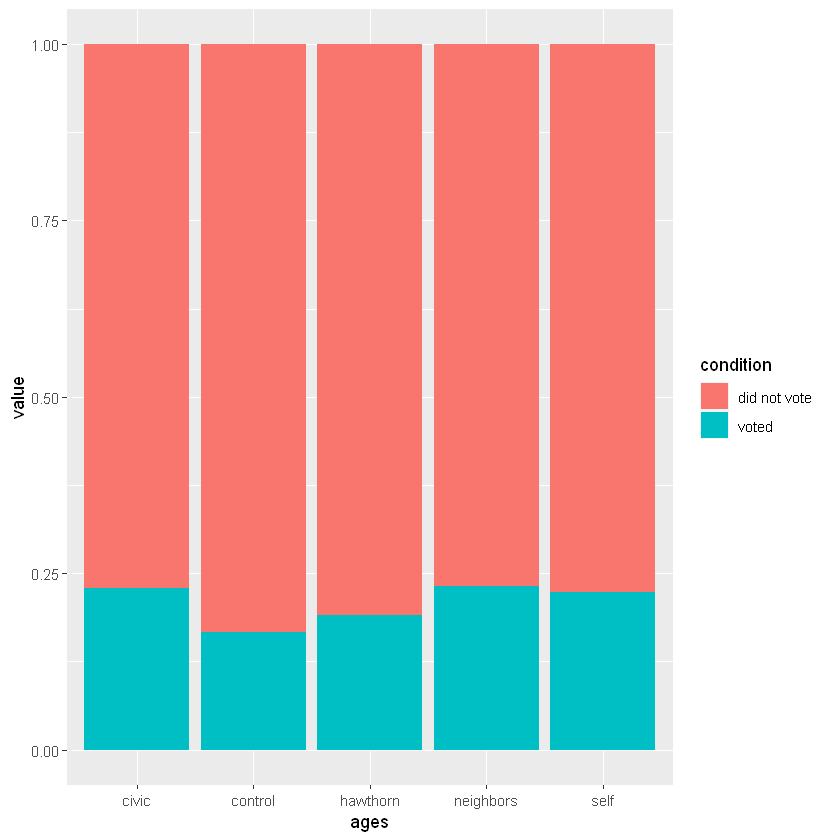

In [133]:
ages <- c( rep("civic",2), rep("hawthorn",2), rep("self",2), rep("neighbors",2),rep("control",2))
condition <- rep(c("voted", "did not vote"),5)
value <- abs(as.numeric(stackedValues))

ggplot_data_stacked_1 <- data.frame(ages,condition,value)

ggplot(ggplot_data_stacked_1, aes(fill=condition, y=value, x=ages)) + 
    geom_bar(position="fill", stat="identity")

# Task 3 - Modeling with logistic regression

## Part 1- 

Build a logistic regression model for voting2006 using the give group variables as the independent variables as well as the age_group variable you created in Task 1.

In [27]:
unlisted_age_group = unlist(ageGroup)

In [28]:
completeData$unlisted_age_group = unlisted_age_group

In [147]:
LogisticRegression <- glm(voting2006 ~ civicduty + hawthorne + self + neighbors + control + unlisted_age_group, data = completeData, family = "binomial")

In [148]:
summary(LogisticRegression)


Call:
glm(formula = voting2006 ~ civicduty + hawthorne + self + neighbors + 
    control + unlisted_age_group, family = "binomial", data = completeData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8696  -0.8358  -0.7322   1.5321   1.8346  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -1.11611    0.47575  -2.346 0.018975 *  
civicduty                     0.18152    0.47527   0.382 0.702509    
hawthorne                    -0.13130    0.47532  -0.276 0.782370    
self                          0.13513    0.47527   0.284 0.776168    
neighbors                     0.20363    0.47525   0.428 0.668309    
control                      -0.34968    0.47535  -0.736 0.461961    
unlisted_age_groupAge_31_40   0.13479    0.03476   3.878 0.000105 ***
unlisted_age_groupAge_41_50   0.06793    0.03097   2.193 0.028289 *  
unlisted_age_groupAge_51_65   0.10878    0.03020   3.602 0.000316 ***
unlisted_age_grou

In the output above, we see the deviance residuals, which are a measure of model fit. This part of output shows the distribution of the deviance residuals for individual cases used in the model.

Next it shows the coefficients, standard errors, the z-statistic, and the associated p-values, here we can see that the group values are not statistically significand, but every age value is (except for age 65+)



We can use the confint function to obtain confidence intervals for the coefficient estimates.

In [31]:
confint(LogisticRegression)

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-2.137056855,-0.23581222
civicduty,-0.697752804,1.20170442
hawthorne,-1.010669767,0.88895291
self,-0.744142703,1.15530277
neighbors,-0.675597979,1.22377635
control,-1.229114846,0.67062342
unlisted_age_groupAge_31_40,0.066746297,0.20301334
unlisted_age_groupAge_41_50,0.007384053,0.12879284
unlisted_age_groupAge_51_65,0.049761170,0.16814798
unlisted_age_groupAge_65_all,-0.078020966,0.05503539


**The coefficient with most significance in this regression model is the p-value Pr(>|z|), which indicates evidence against or for a Null hypothesis**

## Part 2-  Using a threshold of 0.5, what is the accuracy of the logistic regression model?

Taking the definition of [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision) 
- Accuracy = (TP + TN)/(TP + TN + FP + FN)

In [155]:
LogisticRegression_probabilities = predict(LogisticRegression,newdata = completeData)

In [158]:
count = 0
for(i in seq(1,length(LogisticRegression_probabilities))){
    if(LogisticRegression_probabilities[i] > 0.5){
        if(completeData$voting2006[i] == 1){
            count = count + 1
        }
    } else{
        if(completeData$voting2006[i] == 0){
            count = count + 1
        }
    }
}
print(count / length(LogisticRegression_probabilities))

[1] 0.7357516


In [157]:
confMat <- table(completeData$voting2006,LogisticRegression_probabilities)
accuracy <- sum(diag(confMat))/sum(confMat)
print(accuracy) # This value 

[1] 0.02568527


Note: Using other measure of accuracy like (total values correcty predicted / total values, gives an accuracy of 73%). This is because noted that the model mostly predicts that a citizen did not vote. the most likely reason for this can be that our data is not properly distributed (it has 73% "No_vote" values).

### Answer: the accuracy of the model is: 2.5%


## Part 3- Plot the ROC curve for the model and compute the AUC of the model.



In [34]:
library(pROC)
roc_obj <- roc(completeData$voting2006, LogisticRegression_probabilities)
auc(roc_obj)

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.568

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Warning message in plot.ci.se(sens.ci, type = "shape", col = "lightblue"):
"Low definition shape."


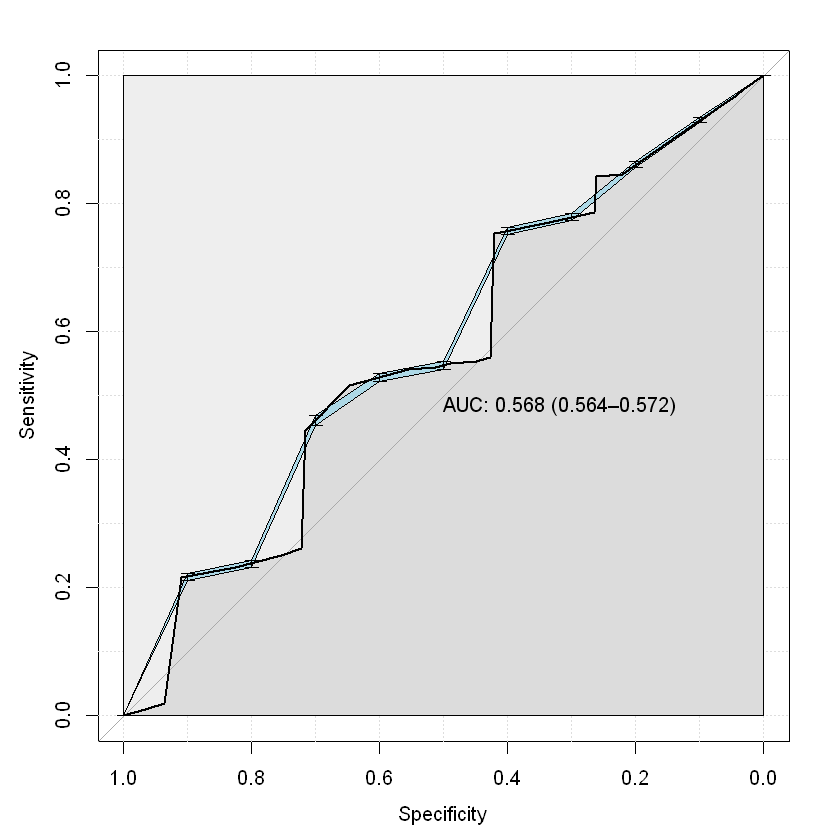

In [35]:
pROC_obj <- roc(completeData$voting2006,LogisticRegression_probabilities,
            smoothed = TRUE,
            # arguments for ci
            ci=TRUE, ci.alpha=0.9, stratified=FALSE,
            # arguments for plot
            plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
            print.auc=TRUE, show.thres=TRUE)


sens.ci <- ci.se(pROC_obj)
plot(sens.ci, type="shape", col="lightblue")

## Warning in plot.ci.se(sens.ci, type = "shape", col = "lightblue"): Low
## definition shape.

plot(sens.ci, type="bars")

An ROC curve is a graph showing the performance of a classification model at all classification tresholds: it plots two parameters, 
- the True Positive Rate
- False positive rate:


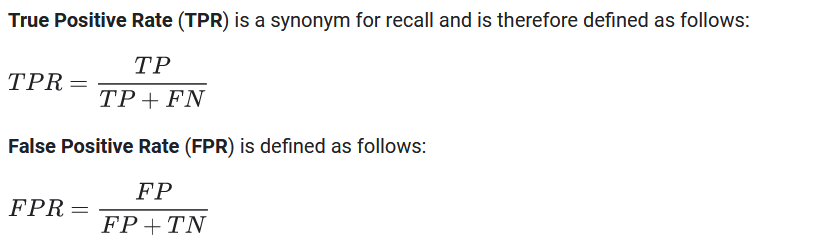

An ROC curve plots TPR vs. FPR at different classification thresholds. 

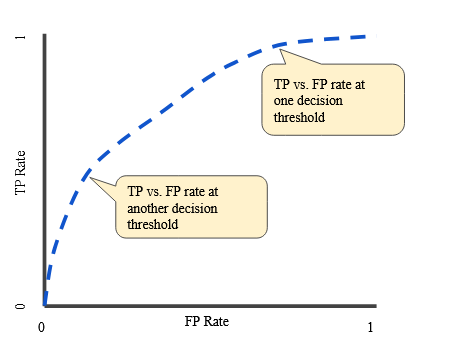

images taken from [google](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

On the other hand AUC measures the entire two-dimensional area underneath the entire ROC curve. AUC provides an aggregate measure of performance across all possible classification thresholds, AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

Here we can see that our **AUC value is of 0.568**, which means that our model does not perform well, in the case of our curve we can see how at certain thresholds it moves agressively, this could mean that the model is getting stuck at some points and then overcompensating, this is motif for future analysis.

# Task 4 - Modeling with Trees

## Part 1- Using the rpart function in R and leaving all the parameters at their default values use the option method=”class”, build the model and plot the tree.

In [38]:
#Grow the tree
Tree_model = rpart(voting2006 ~ civicduty + hawthorne + self + neighbors + control + unlisted_age_group, data = completeData, method="class")


Classification tree:
rpart(formula = voting2006 ~ civicduty + hawthorne + self + neighbors + 
    control + unlisted_age_group, data = completeData, method = "class")

Variables actually used in tree construction:
[1] civicduty          control            hawthorne          neighbors         
[5] self               unlisted_age_group

Root node error: 22510/85185 = 0.26425

n= 85185 

        CP nsplit rel error  xerror      xstd
1 0.039005      0   1.00000 1.00000 0.0057171
2 0.010000     10   0.48925 0.48925 0.0043503
Call:
rpart(formula = voting2006 ~ civicduty + hawthorne + self + neighbors + 
    control + unlisted_age_group, data = completeData, method = "class")
  n= 85185 

          CP nsplit rel error    xerror        xstd
1 0.03900489      0 1.0000000 1.0000000 0.005717127
2 0.01000000     10 0.4892492 0.4892492 0.004350265

Variable importance
unlisted_age_group          civicduty          neighbors            control 
                42                 28                 

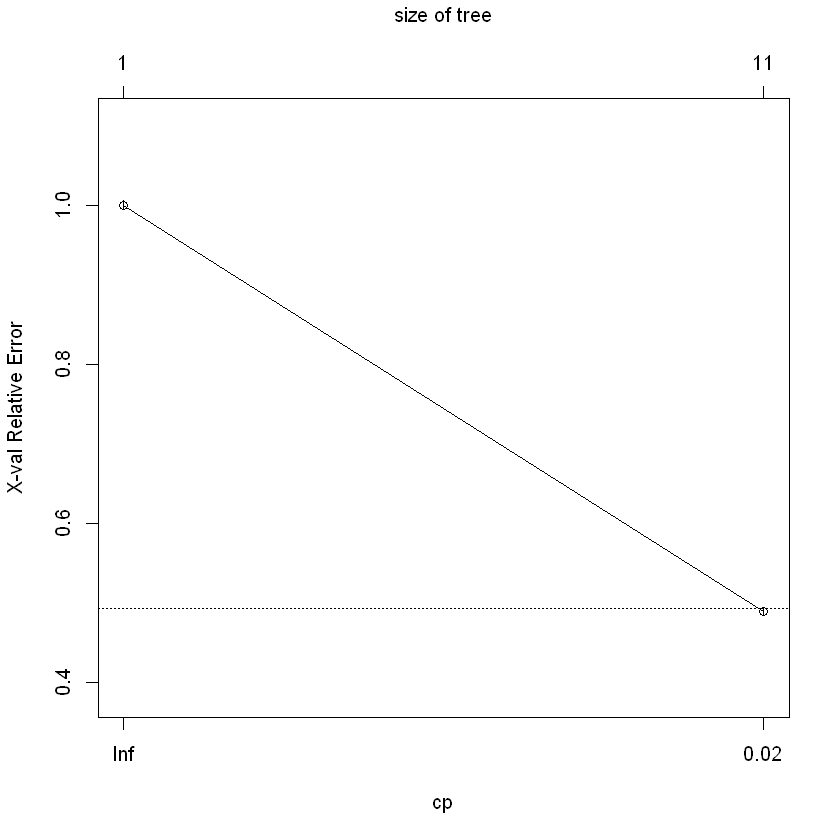

In [39]:
printcp(Tree_model) # display the results
plotcp(Tree_model) # visualize cross-validation results
summary(Tree_model) # detailed summary of splits

ERROR: Error in postscript(file = filename, horizontal = horizontal, ...): cannot open file '/tree.ps'


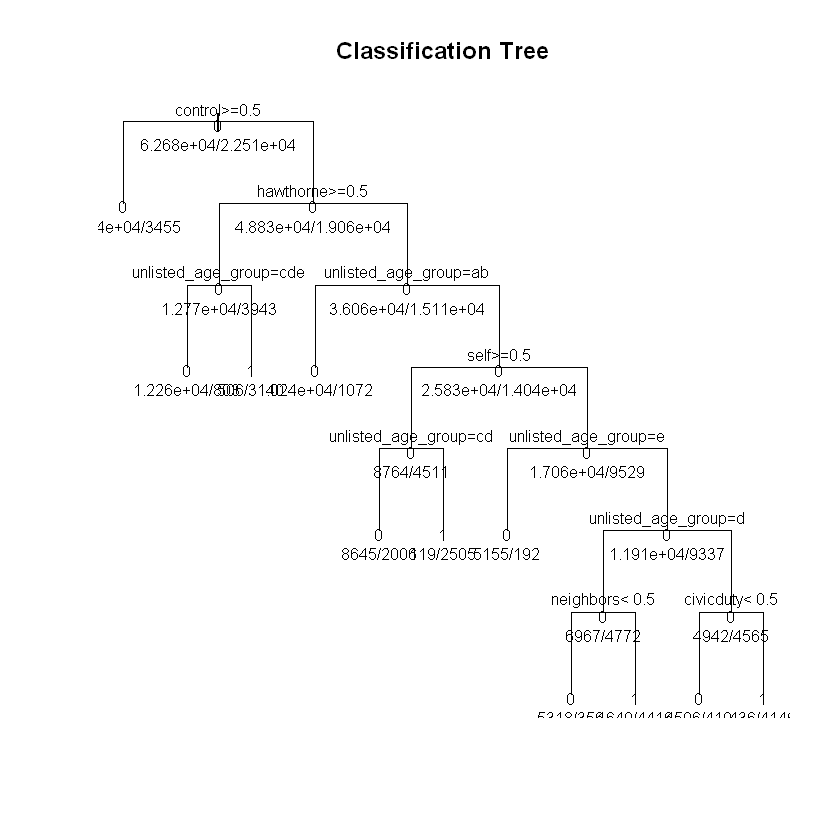

In [159]:
# plot tree
plot(Tree_model, uniform=TRUE,
   main="Classification Tree")
text(Tree_model, use.n=TRUE, all=TRUE, cex=.8)

# create attractive postscript plot of tree
post(Tree_model, file = "/tree.ps",
   title = "Classification Tree")

### Questions - Does it give any insight into the structure of the data that the logistic regression did not? In particular, what is the interaction between the treatment type and age group?
Trees are particularly useful at showing how the analysis developed we can see the "Tree" and its "branches", to analyze how the model developed, The interaction between the treatment type and age group takes the shape of the model calculating the treatment type and then building the branches with the age group variables.


## Part 2- Now, calculate the accuracy of the model. How does it compare to the logistic regression model?If better or worse, why?

In [44]:
tree_model_preds = predict(Tree_model,newdata = completeData, type = "class")

In [142]:
accuracy(table(completeData$voting2006,tree_model_preds))

Warning message in (TP + FP) * (TP + FN):
"NAs produced by integer overflow"


,0,1
0,True positive(59965),False positive(8303)
1,False negative(2710),True negative(14207)


In [46]:
confMat <- table(completeData$voting2006,tree_model_preds)
accuracy_tree <- sum(diag(confMat))/sum(confMat)
print(accuracy_tree)

[1] 0.8707167


### Answers
- The accuracy of the tree model is of 87%.
- It is completely superior to the ~3% of the logistic regression data.
- This is because of the advantages of the decision tree model, as well as the disadvantages of the logistic regression model
    + The decision trees work specially well with data shaped like ours, the discrete categories allow for simple and efective branching. We must also note that not much data featuring is required to make useful decision trees.
    + Logistic regression does not work well with our data because it aims to return probabilities of outcome, and it only has categorical values. Another caveat is that we did not process our data further (eg. equalize the number of voters and non-voters)

### Sources
https://www.statmethods.net/advstats/cart.html

https://stats.idre.ucla.edu/r/dae/logit-regression/

https://www.youtube.com/watch?v=4jRBRDbJemM

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

https://en.wikipedia.org/wiki/Accuracy_and_precision